# Image Classification with Transfer Learning and Self-Attention

In this notebook, we:
- Explain what attention is, why it's useful
- Understand the self-attention mechanism and its math
- Implement transfer learning with a CNN (MobileNetV2) backbone
- Add a custom self-attention layer to enhance representation learning

## 🧠 What is Attention?
Attention is a mechanism that allows neural networks to **focus on the most relevant parts** of the input when making predictions.

In image classification, it helps the model weigh **which parts of an image are important** to make a decision — rather than treating all pixels equally.

Think of it like how humans focus their vision on specific objects in a scene, instead of looking at every part equally.

## 🔬 Why Use Attention in Image Classification?
Traditional CNNs use fixed receptive fields, but attention allows the model to:
- Dynamically weigh features
- Capture **long-range dependencies** (e.g., relation between different parts of an object)
- Improve interpretability (you can visualize where the model focused)

## 🧮 Self-Attention Math
Given an input matrix $X \in \mathbb{R}^{T \times D}$, where:
- $T$ is the number of tokens (image patches or spatial locations)
- $D$ is the embedding dimension

We compute:
1. $Q = XW^Q$ (queries)
2. $K = XW^K$ (keys)
3. $V = XW^V$ (values)

Then attention weights:
$$ A = \text{softmax}\left(\frac{QK^T}{\sqrt{D}}\right) $$

And the output:
$$ Z = AV $$

This gives us a new representation of each token as a **weighted combination of all tokens**, where the weights are based on similarity.

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom self-attention layer
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim  # D

        # Dense layers to learn Wq, Wk, Wv (all shape: [D, D])
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense   = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        # inputs shape: [B, T, D]

        Q = self.query_dense(inputs)  # [B, T, D]
        K = self.key_dense(inputs)    # [B, T, D]
        V = self.value_dense(inputs)  # [B, T, D]

        # Compute attention scores
        attention_scores = tf.matmul(Q, K, transpose_b=True)  # [B, T, T]
        d_k = tf.cast(tf.shape(K)[-1], tf.float32)
        scaled_scores = attention_scores / tf.math.sqrt(d_k)  # scale by sqrt(D)

        # Softmax to get weights
        attention_weights = self.softmax(scaled_scores)       # [B, T, T]

        # Weighted sum of values
        output = tf.matmul(attention_weights, V)              # [B, T, D]
        return output

## 🏗️ Build the Model with MobileNetV2 + Self-Attention

In [11]:
def build_model_with_attention(num_classes=2):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = layers.Input(shape=(224, 224, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x)                             # [B, 7, 7, 1280]
    x = layers.Reshape((49, 1280))(x)             # [B, T=49, D=1280]

    x = SelfAttention(embed_dim=1280)(x)          # [B, 49, 1280]
    x = layers.GlobalAveragePooling1D()(x)        # [B, 1280]
    x = layers.Dense(256, activation='relu')(x)   # [B, 256]
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # [B, num_classes]

    return models.Model(inputs, outputs)

model = build_model_with_attention(num_classes=2)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 49, 1280)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_1                │ (None, 49, 1280)       │     4,919,040 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,505,474 (28.63 MB)

 Trainable params: 5,247,490 (20.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

# Download the dataset from Microsoft (hosted by TensorFlow)
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url, extract=True)

# Get dataset path
dataset_dir = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'validation')

# Load data into TensorFlow datasets
IMG_SIZE = 224
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=(IMG_SIZE, IMG_SIZE))

val_dataset = image_dataset_from_directory(val_dir,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           image_size=(IMG_SIZE, IMG_SIZE))

# Prefetch for performance
train_dataset = train_dataset.prefetch(buffer_size=32)
val_dataset = val_dataset.prefetch(buffer_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [15]:
# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5


63/63 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7963 - loss: 0.5644 - val_accuracy: 0.9670 - val_loss: 0.0804
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9796 - loss: 0.0609 - val_accuracy: 0.9800 - val_loss: 0.0914
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9862 - loss: 0.0561 - val_accuracy: 0.9850 - val_loss: 0.0713
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9891 - loss: 0.0383 - val_accuracy: 0.9780 - val_loss: 0.0768
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9943 - loss: 0.0124 - val_accuracy: 0.9770 - val_loss: 0.0719


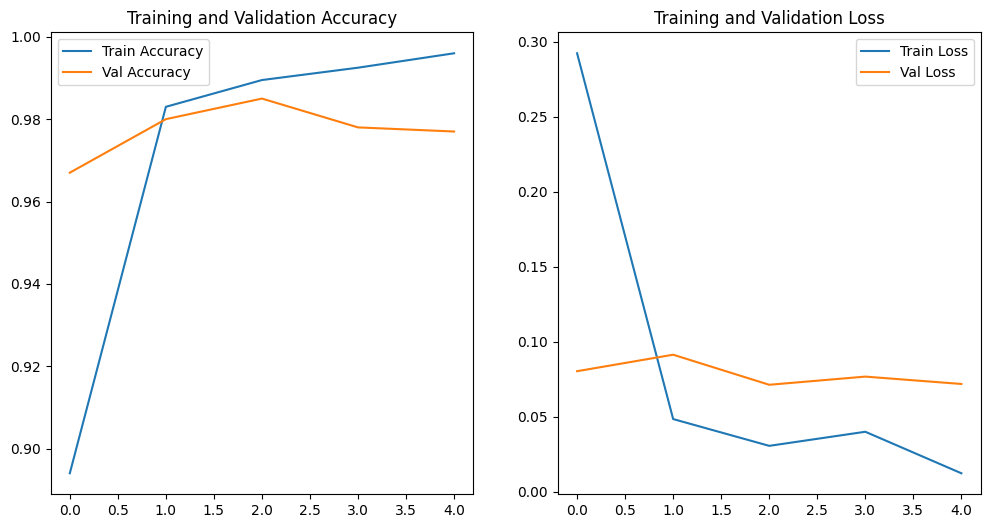

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()